# Importing Necessary Libraries

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import math
import skimage
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn import neighbors
from sklearn import metrics
import seaborn as sns

In [ ]:
!unzip 'Train.zip'

Archive:  Train.zip
replace Train/bird_train/n01530575_102.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip 'Test.zip'

Archive:  Test.zip
replace Test/bird_test/ILSVRC2012_val_00002425.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Q1. KNN Classifier with deep features:**
In this assignment, you will learn to use a pre-trained deep neural network. You are given a set of training images and test images. Load a pre-trained model of your choice (ResNet, etc) and extract deep features for every image from the last fully connected layer. Then compute the image classification accuracy for the test set using KNN classifier (k=3).

## Loading VGG16

In [ ]:
img_width, img_height = 224, 224
model = keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_width, img_height, 3))
from keras.models import Model
layer_name = 'fc2'
model= Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## Extracting Deep Features

In [ ]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
train_dir = '/content/Train'
test_dir = '/content/Test'

In [ ]:
def extract_features(directory, sample_count):

  img_width, img_height = 224, 224  # Default input size for VGG16
  #img_width, img_height = 299, 299


  features = []
  labels = []

  # Preprocess data
  generator = datagen.flow_from_directory(directory, target_size=(img_width,img_height),class_mode='categorical',batch_size=32)

  i = 0

  for inputs_batch, labels_batch in generator:
      features_batch = model.predict(inputs_batch,verbose=None)
      features[i * batch_size: (i + 1) * batch_size] = features_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1

      #print(str(i*batch_size)+' images done!')

      if i * batch_size >= sample_count:
          break

  return features , labels

In [ ]:
train_images , train_labels = extract_features(train_dir,750)

Found 150 images belonging to 5 classes.


In [ ]:
test_images , test_labels =  extract_features(test_dir,500)

Found 100 images belonging to 5 classes.


## Classification Using KNN

In [ ]:
KNN = neighbors.KNeighborsClassifier(n_neighbors = 3)

In [ ]:
KNN.fit(train_images,train_labels)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = KNN.predict(test_images)

In [ ]:
test_accuracy = metrics.accuracy_score(test_labels,y_pred)
test_precision = metrics.precision_score(test_labels,y_pred, average='micro')
test_recall = metrics.recall_score(test_labels,y_pred, average='micro')
test_f1 = metrics.f1_score(test_labels,y_pred, average='micro')
print('Accuracy on the Test Dataset is : ' + str(test_accuracy))
print('Precision on the Test Dataset is : ' + str(test_precision))
print('Recall on the Test Dataset is : ' + str(test_recall))
print('F1 Score on the Test Dataset is : ' + str(test_f1))

Accuracy on the Test Dataset is : 0.73
Precision on the Test Dataset is : 0.73
Recall on the Test Dataset is : 0.73
F1 Score on the Test Dataset is : 0.7299999999999999


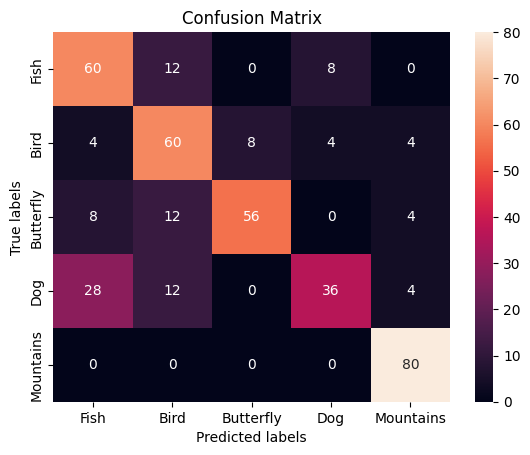

In [ ]:
# Confusion Matrix

cf_matrix = metrics.confusion_matrix(np.asarray(test_labels).argmax(axis=1),np.asarray(y_pred).argmax(axis=1))

classes = ['Fish','Bird','Butterfly','Dog','Mountains']

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

Found 100 images belonging to 5 classes.
Actual Class : Dog
Predicted Class : Fish


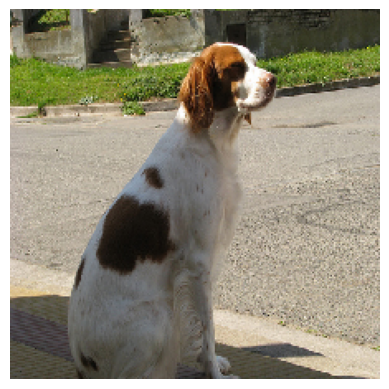

In [ ]:
# Result Cell

g = datagen.flow_from_directory('/content/Test/', target_size=(img_width,img_height),class_mode='categorical',batch_size=1)
for inputs_batch, labels_batch in g:

  features_batch = model.predict(inputs_batch,verbose=None)
  break

predicted_label = KNN.predict(features_batch[0].reshape(1,4096))
plt.imshow(inputs_batch[0])
plt.axis('off')

classes = ['Fish','Bird','Butterfly','Dog','Mountains']

print('Actual Class : ' + str(classes[np.argmax(labels_batch[0])]))
print('Predicted Class : ' + str(classes[np.argmax(predicted_label)]))

# **Q2. Fine-tuning:**
 Fine-tune the last layer using the available data and small learning rate and repeat the same experiment.

## Fine Tuning the Last FC Layer

In [ ]:
img_width, img_height = 224, 224
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(img_width, img_height, 3))
base_model.trainable = False

from keras.models import Model
layer_name = 'fc1'
model= Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# add new classifier layers
fc_2 = Dense(4096, activation='relu')(model.layers[-1].output)
output = Dense(5, activation='softmax')(fc_2)

# define new model
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
train_dir = '/content/Train'
test_dir = '/content/Test'

directory = train_dir

In [ ]:
def create_dataset(directory, sample_count):

  img_width, img_height = 224, 224  # Default input size for VGG16

  images = []
  labels = []

  # Preprocess data
  generator = datagen.flow_from_directory(directory, target_size=(img_width,img_height),class_mode='categorical',batch_size=32)

  i = 0

  for inputs_batch, labels_batch in generator:
      images[i * batch_size: (i + 1) * batch_size] = inputs_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1

      #print(str(i*batch_size)+' images done!')

      if i * batch_size >= sample_count:
          break

  return np.array(images) , np.array(labels)

In [ ]:
train_images , train_labels = create_dataset(train_dir,750)

Found 150 images belonging to 5 classes.


In [ ]:
test_images , test_labels =  create_dataset(test_dir,500)

Found 100 images belonging to 5 classes.


In [ ]:
# Changing the datatype
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# getting the values down to 0 and 1
train_images /= 255
test_images /= 255

In [ ]:
base_learning_rate = 0.00001
# Compiling the model
model.compile(loss = keras.losses.CategoricalCrossentropy() , optimizer = keras.optimizers.Adam(learning_rate = base_learning_rate), metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=30, validation_data = (test_images,test_labels))

Epoch 1/30
23/23 [==============================] - 7s 228ms/step - loss: 1.7257 - accuracy: 0.2280 - val_loss: 1.7045 - val_accuracy: 0.2000
Epoch 2/30
23/23 [==============================] - 5s 243ms/step - loss: 1.6768 - accuracy: 0.2074 - val_loss: 1.6130 - val_accuracy: 0.2000
Epoch 3/30
23/23 [==============================] - 6s 249ms/step - loss: 1.6314 - accuracy: 0.2129 - val_loss: 1.7090 - val_accuracy: 0.2000
Epoch 4/30
23/23 [==============================] - 6s 245ms/step - loss: 1.7062 - accuracy: 0.1964 - val_loss: 1.6890 - val_accuracy: 0.2000
Epoch 5/30
23/23 [==============================] - 5s 204ms/step - loss: 1.6405 - accuracy: 0.2198 - val_loss: 1.6288 - val_accuracy: 0.2000
Epoch 6/30
23/23 [==============================] - 6s 247ms/step - loss: 1.6401 - accuracy: 0.2184 - val_loss: 1.6425 - val_accuracy: 0.2000
Epoch 7/30
23/23 [==============================] - 6s 246ms/step - loss: 1.6354 - accuracy: 0.2033 - val_loss: 1.6604 - val_accuracy: 0.2000
Epoch 

## Extracting Deep Features

In [ ]:
# define new model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
def extract_features(directory, sample_count):

  img_width, img_height = 224, 224  # Default input size for VGG16

  features = []
  labels = []

  # Preprocess data
  generator = datagen.flow_from_directory(directory, target_size=(img_width,img_height),class_mode='categorical',batch_size=32)

  i = 0

  for inputs_batch, labels_batch in generator:
      features_batch = model.predict(inputs_batch,verbose=None)
      features[i * batch_size: (i + 1) * batch_size] = features_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1

      #print(str(i*batch_size)+' images done!')

      if i * batch_size >= sample_count:
          break

  return features , labels

In [ ]:
train_images_features , train_labels = extract_features(train_dir,750)

Found 150 images belonging to 5 classes.


In [ ]:
test_images_features , test_labels =  extract_features(test_dir,500)

Found 100 images belonging to 5 classes.


## Classification Using KNN

In [ ]:
KNN = neighbors.KNeighborsClassifier(n_neighbors = 3)
KNN.fit(train_images_features,train_labels)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = KNN.predict(test_images_features)

In [ ]:
test_accuracy = metrics.accuracy_score(test_labels,y_pred)
test_precision = metrics.precision_score(test_labels,y_pred, average='micro')
test_recall = metrics.recall_score(test_labels,y_pred, average='micro')
test_f1 = metrics.f1_score(test_labels,y_pred, average='micro')
print('Accuracy on the Test Dataset is : ' + str(test_accuracy))
print('Precision on the Test Dataset is : ' + str(test_precision))
print('Recall on the Test Dataset is : ' + str(test_recall))
print('F1 Score on the Test Dataset is : ' + str(test_f1))

Accuracy on the Test Dataset is : 0.8
Precision on the Test Dataset is : 0.8
Recall on the Test Dataset is : 0.8
F1 Score on the Test Dataset is : 0.8000000000000002


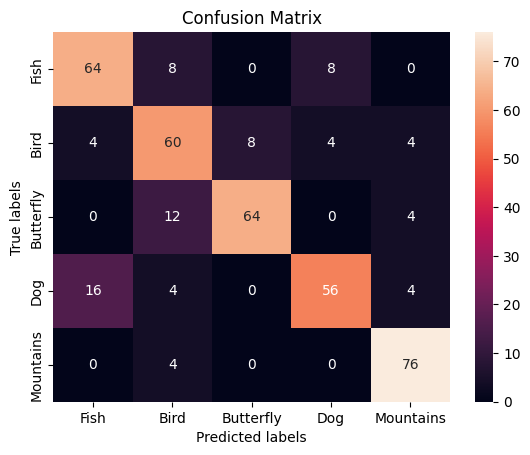

In [ ]:
cf_matrix = metrics.confusion_matrix(np.asarray(test_labels).argmax(axis=1),np.asarray(y_pred).argmax(axis=1))

classes = ['Fish','Bird','Butterfly','Dog','Mountains']

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

Found 100 images belonging to 5 classes.
1/1 [==============================] - 0s 18ms/step
Actual Class : Fish
Predicted Class : Fish


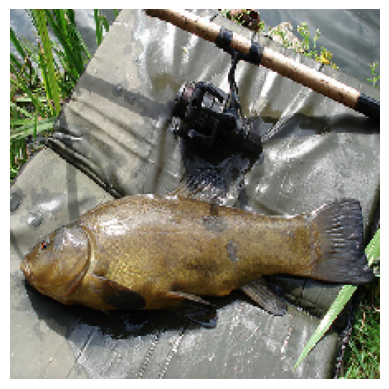

In [ ]:
# Result Cell

g = datagen.flow_from_directory('/content/Test/', target_size=(img_width,img_height),class_mode='categorical',batch_size=1)
for inputs_batch, labels_batch in g:

  features_batch = model.predict(inputs_batch)
  break

predicted_label = KNN.predict(features_batch[0].reshape(1,4096))
plt.imshow(inputs_batch[0])
plt.axis('off')

classes = ['Fish','Bird','Butterfly','Dog','Mountains']

print('Actual Class : ' + str(classes[np.argmax(labels_batch[0])]))
print('Predicted Class : ' + str(classes[np.argmax(predicted_label)]))